# WSI - ćwiczenie 6
## Yaroslav Harbar
### Uczenie (się) ze wzmocnieniem

Celem ćwiczenia jest implementacja algorytmu Q-learning. W tym zadaniu zostało wykorzystane środowisko *Taxi-v3*, które składa się z 2D świata, w którym agentem jest taksówkarz, który musi odebrać klienta i wysadzić go w miejscu docelowym.

In [334]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import time
import pandas as pd

## Środowisko *Taxi-v3*

Kluczowymi elementami algorytmu Q-learning jest *stany* oraz *akcje*.
W środowisku *Taxi-v3* agent może wchodzić w interakcję z otoczeniem za pomocą następujących dyskretnych akcji: jechać do góry, jechać do dołu, jechać w prawo, jechać w lewo, zabrać pasażera i wysadzić pasażera.

| Akcja | Numer akcji |
|-------|-------------|
| jechać do góry   | 0           |
| jechać do dołu   | 1           |
| jechać w prawo  | 2           |
| jechać w lewo   | 3           |
| zabrać pasażera   | 4           |
| wysadzić pasażera   | 5           |

Natomiast stan w środowisku *Taxi-v3* jest reprezentowany jako krotka zawierająca pozycję agenta (taksówkarza), lokalizacja pasażera, który ma być odebrany oraz miejsce docelowe. State = (agent_position_x, agent_position_y, passenger_localization, destination_localization)

| Lokalizacja pasażera \ Miejsce docelowe | Numer |
|-----------------------------------------|------------|
| czerwone                                | 0          |
| zielone                                 | 1          |
| żółte                                   | 2          |
| niebieskie                              | 3          |
| w taksówce (tylko dla pasażera)         | 4          |


In [335]:
env = gym.make('Taxi-v3')
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Na rysunku jest przedstawione środowisko Taxi-v3, gdzie zielony prostokąt jest agentem, litery R, G, Y, B - reprezentują lokalizacje. Jeżeli jedna z tych liter jest pokolorowany na niebiesko, to oznacza, że w tym miejscu jest pasażer, natomiast jeżeli jest pokolorowany na różowo, to oznacza, że to jest miejsce docelowe.

## Algorytm Q-Learning

In [336]:
class QLearning:
    def __init__(self, env_name):
        self.env_name= env_name
        self.env = gym.make(env_name).env
        self.q_table = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        self.rewards_history = []

    def get_parameters(self):
        return [
            self.env_name,
            self.env,
            self.q_table,
            self.rewards_history
        ]

    def exploration(self, epsilon, state):
        if np.random.rand() > epsilon:
            return np.argmax(self.q_table[state])
        return self.env.action_space.sample()

    def train(self, train_episodes, epsilon, beta, gamma, evaluate_step, evaluate_episodes, print_evaluate_info=False):
        for i in range(train_episodes):
            state = self.env.reset()
            episode_reward = 0
            done = False

            while not done:
                action = self.exploration(epsilon, state)
                next_state, reward, done, info = self.env.step(action)
                self.q_table[state][action] = self.q_table[state][action] + beta * (reward + gamma * np.max(self.q_table[next_state, :]) - self.q_table[state][action])
                state = next_state
                episode_reward += reward

            self.rewards_history.append(episode_reward)

            if i > 0 and i % evaluate_step == 0 and print_evaluate_info:
                print("Evaluate #", i // evaluate_step, ' Mean reward: ', self.evaluate(evaluate_episodes))

    def evaluate(self, evaluate_episodes):
        episodes_rewards = []
        for i in range(evaluate_episodes):
            state = self.env.reset()
            episode_reward = 0
            done = False

            while not done:
                action = np.argmax(self.q_table[state])
                next_state, reward, done, info = self.env.step(action)
                state = next_state
                episode_reward += reward

            episodes_rewards.append(episode_reward)

        return np.mean(episodes_rewards)

In [337]:
class Simulation:
    def __init__(self):
        self.simulation_list = []

    def get_parametrs(self):
        return [self.simulation_list]

    def simulate(self, train_episodes, epsilon, beta, gamma, evaluate_step, evaluate_episodes, print_evaluate_info=False):
        qL = QLearning("Taxi-v3")

        start_time = time.time()
        qL.train(train_episodes, epsilon, beta, gamma, evaluate_step, evaluate_episodes, print_evaluate_info)
        end_time = time.time()

        self.simulation_list.append([train_episodes, epsilon, beta, gamma, qL.evaluate(evaluate_episodes), end_time - start_time])

        plt.plot(qL.rewards_history)
        plt.show()

    def get_simulation_table(self):
        return pd.DataFrame(self.simulation_list, columns=["episodes", "epsilon", "beta", "gamma", "evaluation", "train time"])


In [338]:
qL = QLearning("Taxi-v3")
qL.train(train_episodes=10000, epsilon=0.01, beta=0.6, gamma=0.8, evaluate_step=1000, evaluate_episodes=10, print_evaluate_info=True)

Evaluate # 1  Mean reward:  7.6
Evaluate # 2  Mean reward:  7.7
Evaluate # 3  Mean reward:  8.0
Evaluate # 4  Mean reward:  7.1
Evaluate # 5  Mean reward:  7.8
Evaluate # 6  Mean reward:  8.8
Evaluate # 7  Mean reward:  7.9
Evaluate # 8  Mean reward:  8.2
Evaluate # 9  Mean reward:  8.1


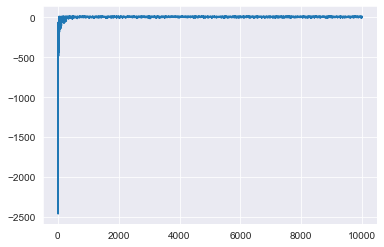

In [339]:
plt.plot(qL.rewards_history)
plt.show()

Evaluate # 1  Mean reward:  9.4
Evaluate # 2  Mean reward:  7.8
Evaluate # 3  Mean reward:  7.5
Evaluate # 4  Mean reward:  8.0
Evaluate # 5  Mean reward:  8.0
Evaluate # 6  Mean reward:  8.5
Evaluate # 7  Mean reward:  7.9
Evaluate # 8  Mean reward:  7.4
Evaluate # 9  Mean reward:  7.3


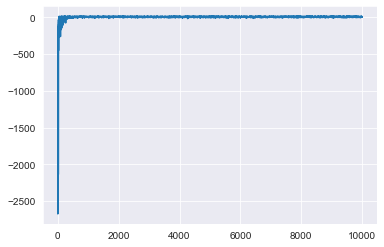

In [340]:
simulation = Simulation()
simulation.simulate(train_episodes=10000, epsilon=0.01, beta=0.6, gamma=0.8, evaluate_step=1000, evaluate_episodes=10, print_evaluate_info=True)

Evaluate # 1  Mean reward:  7.7
Evaluate # 2  Mean reward:  9.0
Evaluate # 3  Mean reward:  7.7
Evaluate # 4  Mean reward:  6.8
Evaluate # 5  Mean reward:  7.4
Evaluate # 6  Mean reward:  7.8
Evaluate # 7  Mean reward:  8.0
Evaluate # 8  Mean reward:  7.1
Evaluate # 9  Mean reward:  7.3


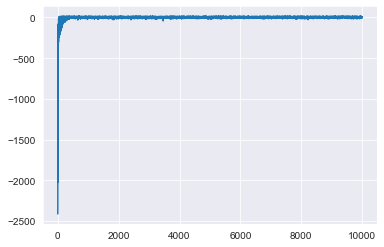

In [341]:
simulation.simulate(train_episodes=10000, epsilon=0.05, beta=0.6, gamma=0.8, evaluate_step=1000, evaluate_episodes=10, print_evaluate_info=True)

Evaluate # 1  Mean reward:  7.3
Evaluate # 2  Mean reward:  7.2
Evaluate # 3  Mean reward:  8.0
Evaluate # 4  Mean reward:  7.5
Evaluate # 5  Mean reward:  8.3
Evaluate # 6  Mean reward:  7.4
Evaluate # 7  Mean reward:  8.7
Evaluate # 8  Mean reward:  8.7
Evaluate # 9  Mean reward:  8.3


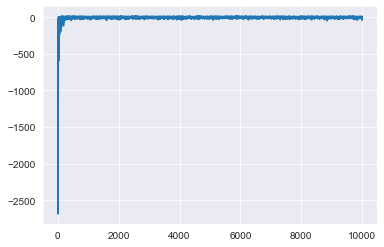

In [342]:
simulation.simulate(train_episodes=10000, epsilon=0.1, beta=0.9, gamma=0.5, evaluate_step=1000, evaluate_episodes=10, print_evaluate_info=True)

In [343]:
simulation.get_simulation_table()

,episodes,epsilon,beta,gamma,evaluation,train time
0,10000,0.01,0.6,0.8,9.0,5.060946
1,10000,0.05,0.6,0.8,9.2,4.953387
2,10000,0.10,0.9,0.5,9.2,5.729501
